## 이 노드의 루브릭                 
--- 

1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?           
    : CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.          
    
    
2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?           
    : Augmentation 적용을 통해 Augmentation 미적용시 대비 5% 이상의 성능 향상을 확인함            
    
    
3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석 하였는가?              
    : 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.

## 목차               
---

1. Augmentation을 적용한 데이터셋 만들기         
2. 모델 만들기(ResNet-50)          
3. 모델 훈련하기              
    : sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용      
    
4. 훈련과정 시각화하기        
5. Augmentation에 의한 모델 성능 비교            

### 0. 필요한 라이브러리 임포트            
---

In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('필요한 라이브러리 임포트 완료')

필요한 라이브러리 임포트 완료


## 1. Augmentation을 적용한 데이터셋 만들기               
---

In [3]:
#데이터셋 가져오기
import urllib3

urllib3.disable_warnings()

(train_data_aug, test_data_aug), data_info = tfds.load(
        'stanford_dogs',
        split=['train','test'],
        shuffle_files=True,
        with_info=True)

print('데이터셋 가져오기')

데이터셋 가져오기


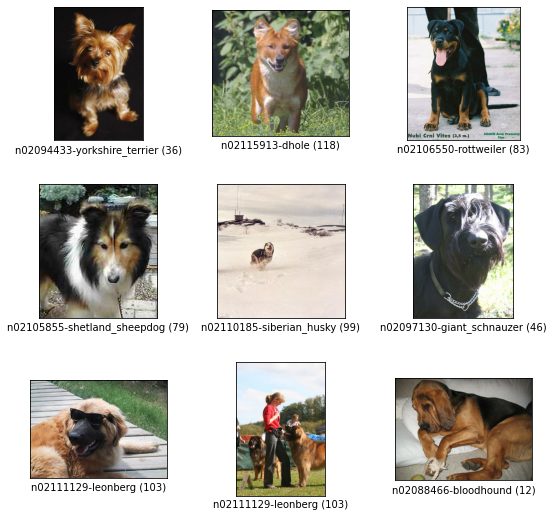

In [4]:
figure = tfds.show_examples(train_data_aug, data_info)

### 기본적인 전처리 함수 적용

In [5]:
def normalize_an_resize(image, label):
    image = tf.image.resize(image, [224,224])
    return tf.cast(image, tf.float32)/225., label

## 1. Tensorflow에서 제공하는 기본 API를 활용한 기본 Augmentation

- 랜덤 좌우반전        
- 랜덤 상하반전            
- 랜덤 콘트라스트       
- 랜덤 밝기 조정

과 같은 간단한 augmentation을 진행해본다.

In [6]:
SEED=28

In [7]:
def basic_augmentation(image, label):
    
    image = tf.image.random_flip_left_right(image, SEED)
    image = tf.image.random_flip_up_down(image, SEED)
    image = tf.image.random_contrast(image, 0.1, 0.8)
    image = tf.image.random_brightness(image, max_delta=0.5)
    
    return image, label

## 2. CutMix

![컷믹스](./PostingPic/cutmix.png)

- 컷믹스는 이런 기법이다.

In [8]:
#바운딩 박스 부분을 찝어줄 수 있도록 함수 생성
def get_clip_box(image_a, image_b):
    
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # 박스 센터 부분의 좌표 기억
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)

    # 박스의 너비, 높이 가져오기
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

In [9]:
#두 이미지를 섞을 수 있도록 하는 함수 생성
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    
    #섞으려 하는 바탕 이미지의 크기를 기억
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    
    #영역을 세 군데로 나누어, 1(a이미지의 일부) + 2(b이미지의 일부) + 3(a이미지의 일부)로 더함
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [10]:
#라벨도 동일하게 섞어준다.
def mix_2_label(label_a, label_b, xa, ya, xb, yb, num_classes=120):
    
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_label

In [11]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        
        image_b = image[j]
        label_b = label[j]
        
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

## 3. MixUp

![믹스업](./PostingPic/mixup.png)

In [14]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        
        image_b = image[j]
        label_b = label[j]
        
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

## Augmentation을 적용한 데이터셋 만들기

In [37]:
def apply_augmentation_on_dataset(ds, is_test=False, batch_size=16, 
                                  with_aug=False, 
                                  with_cut=False,
                                  with_mix=False):
    
    ds = ds.map(
        normalize_and_resize, 
        num_parallel_calls=2)
    
    #학습데이터에 basic_augmentation을 적용할 경우
    if not is_test:
        if with_aug:
            ds = ds.map(basic_augmentation)
        
        ds = ds.batch(batch_size)
    
        if with_cutmix:
            ds = ds.map(cutmix,
            num_parallel_calls=2)
        else:
            ds = ds.map(onehot,
            num_parallel_calls=2)
        
        if with_mixup:
            ds = ds.map(mixup,
                       num_paraller_calls=2)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

## 2.모델 만들기                
---

In [15]:
num_class = data_info.features["label"].num_classes

In [20]:
#아무것도 적용하지 않을 모델
resnet50_pure = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_class, activation = 'softmax')
])

In [16]:
#기본 augmentation을 적용할 모델
resnet50_basic = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_class, activation = 'softmax')
])

In [17]:
#cutmix를 함께 적용할 모델
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_class, activation = 'softmax')
])

In [18]:
#mixup을 적용할 모델
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_class, activation = 'softmax')
])

In [ ]:
(train_data, test_data), data_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

train_data_pure = apply_normalize_on_dataset(train_data, 
                                             with_basic_aug=False, with_cutmix=False, with_mixup=False)
train_data_basic = apply_normalize_on_dataset(train_data, 
                                              with_basic_aug=True, with_cutmix=False, with_mixup=False)

In [ ]:
train_data_cutmix = apply_normalize_on_dataset(train_data, 
                                               with_basic_aug=True, with_cutmix=True, with_mixup=False)
train_data_mixup = apply_normalize_on_dataset(train_data, 
                                              with_basic_aug=True, with_cutmix=False, with_mixup=True)

ds_test = apply_normalize_on_dataset(test_data, is_test = True)

> 기존의 applay_normalize_on_dataset 함수를 약간 개량하여 cutmix, mixup을 적용할 방안을 마련해주었다.

## 3. 모델 학습시키기           
---

In [19]:
EPOCH = 20

tf.random.set_seed(2000)

In [ ]:
resnet50_pure.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],)

history_resnet50_pure = resnet50_basic.fit(
    train_data_pure, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(data_info.splits['train'].num_examples/16),
    validation_steps=int(data_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

![결과](./PostingPic/pure.png)

> 빠른 진행을 위해 lms에서 훈련시켰다 ^^...

In [ ]:
resnet50_basic.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],)

history_resnet50_basic = resnet50_basic.fit(
    train_data_basic, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(data_info.splits['train'].num_examples/16),
    validation_steps=int(data_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

![basic](./PostingPic/basic.png)

## 4.훈련과정 시각화하기                
----

> Augmentation을 아예 적용하지 않은 pure 모델과, tensorflow에서 적용하는 가장 기본적인 augment를 적용한 basic 모델의         
> 학습 과정 시각화는 다음과 같다

![결과](./PostingPic/pure_and_basic_result.png)